# A network-based method to harmonize data classifications
## SCIAN-CIIU-NAICS

In [3]:
## Cargamos paquetes
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install py2cytoscape
from py2cytoscape import util as cy
from py2cytoscape import cytoscapejs as cyjs
import requests
import json
from IPython.display import Image
from IPython.display import Markdown as md
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.1 MB/s eta 0:00:00
  Created wheel for py2cytoscape: filename=py2cytoscape-0.7.1-py3-none-any.whl size=78813 sha256=00e0ba635ad688b5469ea61085234c3989742e208a99515205e7eef4ce4864a4
  Stored in directory: /root/.cache/pip/wheels/25/08/d4/fd171c87154431403e34d9ff7cd9d51a6e4adbcf67e4fa96ca
Successfully built py2cytoscape


<IPython.core.display.Javascript object>

In [4]:
## Definimos rutas donde se encuentran las correspondencias scian-ciiu
FILE_PATH = os.getcwd()
DATA_PATH = os.path.join(FILE_PATH, "data")
OUTPUT_PATH = os.path.join(FILE_PATH, "output")
CW_ONET_SINCO_FILE_PATH = os.path.join(DATA_PATH, "sinco-onet.xlsx")
PAPER_AUTOMATIZACION_FILE_PATH = os.path.join(DATA_PATH, "frey2016.pdf")

In [5]:
## Cargamos el cw
cw_sinco_onet = pd.read_excel(CW_ONET_SINCO_FILE_PATH)
cw_sinco_onet

,soccode8dig,onetsoccode,title,soc2,cve_broad,soccode,soctitle,clave,sinco,nombre_sinco,soc,nombre_soc
0,11000000,11-1011.03,Chief Sustainability Officers,111010,11-1010,11-1011,Chief Executives,1,1111,Altas autoridades gubernamentales y jurisdicci...,11 1010,Ejecutivos en jefe
1,11000000,11-1011.00,Chief Executives,111010,11-1010,11-1011,Chief Executives,1,1111,Altas autoridades gubernamentales y jurisdicci...,11 1010,Ejecutivos en jefe
2,11000000,11-1031.00,Legislators,111030,11-1030,11-1031,Legislators,1,1111,Altas autoridades gubernamentales y jurisdicci...,11 1030,Legisladores
3,11000000,11-1031.00,Legislators,111030,11-1030,11-1031,Legislators,1,1112,Legisladores,11 1030,Legisladores
4,11000000,11-1011.03,Chief Sustainability Officers,111010,11-1010,11-1011,Chief Executives,1,1113,Presidentes y autoridades municipales,11 1010,Ejecutivos en jefe
...,...,...,...,...,...,...,...,...,...,...,...,...
2338,55000000,43-5021.00,Couriers and Messengers,435020,43-5020,43-5021,Couriers and Messengers,397,9722,Repartidores de mensajería (a pie y en bicicle...,43 5020,Mensajeros y repartidores
2339,55000000,43-5021.00,Couriers and Messengers,435020,43-5020,43-5021,Couriers and Messengers,397,9723,Repartidores de mercancías (a pie y en bicicleta),43 5020,Mensajeros y repartidores
2340,55000000,43-5041.00,"Meter Readers, Utilities",435040,43-5040,43-5041,"Meter Readers, Utilities",398,9731,Lecturistas de medidores,43 5040,Lectores de medidores de servicios públicos
2341,55000000,41-2012.00,Gaming Change Persons and Booth Cashiers,412010,41-2010,41-2012,Gambling Change Persons and Booth Cashiers,399,9732,Recolectores de dinero,41 2010,Cajeros


In [6]:
## Nos quedamos con las columnas soccode, soctitle, sinco, nombre_sinco
cw_sinco_onet = cw_sinco_onet[["onetsoccode", "sinco"]]
cw_sinco_onet

,onetsoccode,sinco
0,11-1011.03,1111
1,11-1011.00,1111
2,11-1031.00,1111
3,11-1031.00,1112
4,11-1011.03,1113
...,...,...
2338,43-5021.00,9722
2339,43-5021.00,9723
2340,43-5041.00,9731
2341,41-2012.00,9732


In [7]:
### Nos quedamos con los valores del codigo onetsoc anteriores al punto
cw_sinco_onet.onetsoccode = cw_sinco_onet.onetsoccode.apply(lambda x : x.split(".")[0])

<ipython-input-7-4521b0cfcf68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_sinco_onet.onetsoccode = cw_sinco_onet.onetsoccode.apply(lambda x : x.split(".")[0])


In [8]:
### Generamos un re etiquetamiento para indizar los códigos onet a enteros

indice_to_onet = {i+1 : j for i,j in enumerate(cw_sinco_onet.onetsoccode.unique())}
onet_to_indice = {j : i+1  for i,j in enumerate(cw_sinco_onet.onetsoccode.unique())}
cw_sinco_onet["onetsoccode"] = cw_sinco_onet["onetsoccode"].replace(onet_to_indice)
cw_sinco_onet

<ipython-input-8-df7b1df3bbc7>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cw_sinco_onet["onetsoccode"] = cw_sinco_onet["onetsoccode"].replace(onet_to_indice)
<ipython-input-8-df7b1df3bbc7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_sinco_onet["onetsoccode"] = cw_sinco_onet["onetsoccode"].replace(onet_to_indice)


,onetsoccode,sinco
0,1,1111
1,1,1111
2,2,1111
3,2,1112
4,1,1113
...,...,...
2338,745,9722
2339,745,9723
2340,749,9731
2341,437,9732


In [9]:
indice_to_onet

{1: '11-1011',
 2: '11-1031',
 3: '11-1021',
 4: '11-9141',
 5: '21-2021',
 6: '11-2011',
 7: '11-3061',
 8: '11-3071',
 9: '11-3111',
 10: '11-3121',
 11: '11-3031',
 12: '11-9111',
 13: '11-9161',
 14: '11-9199',
 15: '11-9151',
 16: '11-3131',
 17: '11-9039',
 18: '11-9031',
 19: '11-9032',
 20: '11-9033',
 21: '23-1022',
 22: '23-1023',
 23: '23-1021',
 24: '55-1013',
 25: '55-1014',
 26: '55-1017',
 27: '55-1015',
 28: '55-1012',
 29: '55-1011',
 30: '55-1019',
 31: '55-1016',
 32: '11-9013',
 33: '11-3051',
 34: '11-9021',
 35: '11-9041',
 36: '11-3021',
 37: '11-9121',
 38: '11-2022',
 39: '11-2021',
 40: '11-9051',
 41: '11-9081',
 42: '27-2012',
 43: '27-2011',
 44: '25-4012',
 45: '25-4013',
 46: '25-4011',
 47: '11-9071',
 48: '33-1012',
 49: '33-1011',
 50: '33-1099',
 51: '45-1011',
 52: '47-1011',
 53: '51-1011',
 54: '49-1011',
 55: '39-9041',
 56: '13-1011',
 57: '39-4031',
 58: '11-9131',
 59: '13-1022',
 60: '13-1023',
 61: '13-1021',
 62: '13-1071',
 63: '13-1075',
 

## ONET-SINCO

In [10]:
"""
generate graph/network here
"""

# empty graph/network
G_onet_sinco = nx.Graph()


# add edges
for k in cw_sinco_onet.index:
    i = tuple(cw_sinco_onet.iloc[[k]]["onetsoccode"].values)[0]
    j = tuple(cw_sinco_onet.iloc[[k]]["sinco"].values)[0]
    G_onet_sinco.add_edge(int(i),int(j))


In [11]:
def basic_stats(G):
    print("nodes: %d" % G.number_of_nodes())
    print("edges: %d" % G.number_of_edges())

In [12]:
basic_stats(G_onet_sinco)

nodes: 1180
edges: 1646


In [13]:
set_i = cw_sinco_onet[['onetsoccode']]
set_i = set_i.drop_duplicates(keep='first')
set_i['set_type']=int(1)
set_j = cw_sinco_onet[['sinco']]
set_j = set_j.drop_duplicates(keep='first')
set_j['set_type']=int(2)


set_i.onetsoccode = set_i.onetsoccode.astype(int)
set_i

set_j.sinco = set_j.sinco.astype(int)
set_j


# node attributes
node_type = set_i.set_index("onetsoccode").set_type.to_dict()
node_type.update(set_j.set_index("sinco").set_type.to_dict() )
for k in node_type:
    node_type[k]=int(node_type[k])

# assign attributes to networkx G
nx.set_node_attributes(G_onet_sinco,node_type,"n_type")




In [14]:
# move network from networkx to cy
G_onet_sinco.node = G_onet_sinco.nodes
cytoscape_network = cy.from_networkx(G_onet_sinco)

In [15]:
# Basic Setup
PORT_NUMBER = 1234
IP = 'localhost'
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}
requests.delete(BASE + 'session')

ConnectionError: HTTPConnectionPool(host='localhost', port=1234): Max retries exceeded with url: /v1/session (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7dfb8401acd0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [16]:
res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))

ConnectionError: HTTPConnectionPool(host='localhost', port=1234): Max retries exceeded with url: /v1/networks (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7dfb849e02d0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [17]:
style_name = 'Basic_Style'

my_style = {
  "title" : style_name,
  "mappings" : [{
    "mappingType" : "discrete",
    "mappingColumn" : "n_type",
    "mappingColumnType" : "Double",
    "visualProperty" : "NODE_FILL_COLOR",
       "map" : [ {
      "key" : "1",
      "value" : "#CC0000"
    }, {
      "key" : "2",
      "value" : "#009999"
    }]
  }],
   'defaults': [{
       'visualProperty': 'EDGE_TRANSPARENCY',
       'value': 255
  }, {
    "visualProperty" : "NODE_SIZE",
    'value': 20
  }, {
    "visualProperty" : "EDGE_WIDTH",
    'value': 1
  },{
       'visualProperty': 'NODE_LABEL_FONT_SIZE',
       'value': 12
   },{
       'visualProperty': 'NODE_LABEL_TRANSPARENCY',
       'value': 250
   }, {
       'visualProperty': 'NODE_TRANSPARENCY',
       'value': 250
   }]
}

# Create new Visual Style
res = requests.post(BASE + "styles", data=json.dumps(my_style), headers=HEADERS)
new_style_name = res.json()['title']

# Apply it to current netwrok
requests.get(BASE + 'apply/styles/' + new_style_name + '/' + str(new_suid))

# Display
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

ConnectionError: HTTPConnectionPool(host='localhost', port=1234): Max retries exceeded with url: /v1/styles (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7dfb83c621d0>: Failed to establish a new connection: [Errno 111] Connection refused'))

## 4 Main methodology  

### 4.1 An error-free solution to the many-to-many problem

The principle behind the method is rather simple: we are going to define a new, fictional, target classification, for each of the connected components in the network.

In [18]:
nc = nx.number_connected_components(G_onet_sinco)
nc


170

The new classification will have 151 industry classes. Each of the CIIU and each of the  SCIAN 2018 will converge towards one (and one only) of these 151 new classes.

With CIIU denoted with $i$, SCIAN 2018 with $j$, and the new classification with $k$. The concordance function is in this case


\begin{equation}
f^{CC}\left(\mathbf{C}_{ij}\right) = \left[
\begin{array}{c}
T_{ik} \\
T_{jk}
\end{array}
\right]
\end{equation}


That is, in this case, the concordance function (CC for connected components) has two outputs: one transformation matrix for $i$ and one for $j$. In practical terms we need to identify which of the CIIU and SCIAN belong to which component. The following code does that, returning the two transformation matrices $T_{ik}$ and $T_{jk}$

## 6 The complex case in a many-to-many mapping
### 6.1 When the network has a large connected component

Let's consider a case where the concordance network has one large connected component. It may not be the only component, but let us say that it dominates the network significantly. In this case the method outlined this far is not suited to harmonize the classifications, as we would only have one (or very few) final classification.

We can however apply a modification of this method -- still based on network analysis -- that can provide an elegant solution, even though it is not error free.

The core idea behind the modified method is to identify the clusters (communities, more precisely) in the concordance network, and assign a new "target" classification to each of the clusters.

While a handful of components are small isolates, the majority of the concordance network is made of one large component, which is kept together only by few bridging nodes.

One solution is to use Cytoscape to identify this bridges and disconnect the components by hand. A quicker way to obtain the same result is to run a community discovery algorithm.

In this example I use 'label propagation' algorithm, but several options are possible.

In [19]:
from networkx.algorithms import community

In [21]:
C2 = community.label_propagation_communities(G_onet_sinco)

In [22]:
list_comp2=sorted(C2, key = len, reverse=True)
nc2 = len(list_comp2)
nc2

238

In [23]:
list_comp2

[{176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  2321,
  2715},
 {546,
  547,
  548,
  549,
  550,
  6111,
  6112,
  6113,
  6114,
  6115,
  6116,
  6117,
  6119,
  6121,
  6122,
  6123,
  6124,
  6125,
  6126,
  6127,
  6131,
  6212,
  6223,
  6311,
  6999,
  9111,
  9112,
  9113},
 {604,
  605,
  606,
  642,
  643,
  644,
  645,
  646,
  647,
  648,
  670,
  674,
  682,
  683,
  7511,
  7512,
  7514,
  7515,
  7517,
  8133,
  8161,
  8162,
  8171,
  9236,
  9237,
  9239},
 {611,
  612,
  613,
  614,
  615,
  616,
  617,
  618,
  619,
  715,
  7321,
  7612,
  7613,
  7999,
  8143,
  8144,
  8999,
  9231,
  9232,
  9233,
  9234,
  9235},
 {293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  303,
  2621,
  2623,
  2624,
  2631,
  2633,
  2635,
  2641,
  2643,
  2645},
 {344,

In [24]:
# final concordance tables generation
C123=pd.DataFrame(columns= ["code","code_3","s"])

i = 0
for c in range(nc2):
    code_3 =c+1
    for n in list_comp2[c]:
        C123.loc[i] = 0
        C123.loc[i]["code"] = n
        C123.loc[i]["code_3"] = code_3
        C123.loc[i]["s"] = np.floor(n / (10**(6) ) )
        i += 1



Streaming output truncated to the last 5000 lines.

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  C123.loc[i]["code_3"] = code_3
<ipython-input-24-b3fbd95505d1>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment

In [25]:
C123

,code,code_3,s
0,2321,1,0
1,2715,1,0
2,176,1,0
3,177,1,0
4,178,1,0
...,...,...,...
1175,741,236,0
1176,742,237,0
1177,9663,237,0
1178,9731,238,0


In [26]:
C123["s"] = 1
C123.loc[C123.code.apply(lambda x: len(str(x))==4 ), "s"] = 2
C123

,code,code_3,s
0,2321,1,2
1,2715,1,2
2,176,1,1
3,177,1,1
4,178,1,1
...,...,...,...
1175,741,236,1
1176,742,237,1
1177,9663,237,2
1178,9731,238,2


In [27]:
T13=C123.loc[C123["s"]== 1]
T23=C123.loc[C123["s"]== 2]

T13.columns=["onetsoccode","new_code","s"]
T23.columns=["sinco","new_code","s"]


In [28]:
T13

,onetsoccode,new_code,s
2,176,1,1
3,177,1,1
4,178,1,1
5,179,1,1
6,180,1,1
...,...,...,...
1171,717,234,1
1172,728,235,1
1175,741,236,1
1176,742,237,1


In [29]:
T23

,sinco,new_code,s
0,2321,1,2
1,2715,1,2
39,9111,2,2
40,9112,2,2
41,9113,2,2
...,...,...,...
1170,9211,234,2
1173,9311,235,2
1174,9633,236,2
1177,9663,237,2


In [30]:
C123_exporta = C123.copy()
C123_exporta.columns = ["codigo", "codigo_nuevo", "clasificador"]
C123_exporta.loc[C123_exporta.clasificador==1,"clasificador"] = "onet"
C123_exporta.loc[C123_exporta.clasificador==2,"clasificador"] = "sinco"
C123_exporta["codigo"] = C123_exporta.codigo.replace(indice_to_onet)
C123_exporta

<ipython-input-30-38785869b906>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'onet' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  C123_exporta.loc[C123_exporta.clasificador==1,"clasificador"] = "onet"


,codigo,codigo_nuevo,clasificador
0,2321,1,sinco
1,2715,1,sinco
2,25-1011,1,onet
3,25-1022,1,onet
4,25-1021,1,onet
...,...,...,...
1175,53-6021,236,onet
1176,47-4041,237,onet
1177,9663,237,sinco
1178,9731,238,sinco


In [31]:
## Cargamos cw para agregar los nombres de las actividades
cw_sinco_onet_nombres = pd.read_excel(CW_ONET_SINCO_FILE_PATH)[["onetsoccode", "soctitle", "sinco", "nombre_sinco"]]
cw_sinco_onet_nombres.onetsoccode = cw_sinco_onet_nombres.onetsoccode.apply(lambda x : x.split(".")[0])
cw_sinco_onet_nombres

,onetsoccode,soctitle,sinco,nombre_sinco
0,11-1011,Chief Executives,1111,Altas autoridades gubernamentales y jurisdicci...
1,11-1011,Chief Executives,1111,Altas autoridades gubernamentales y jurisdicci...
2,11-1031,Legislators,1111,Altas autoridades gubernamentales y jurisdicci...
3,11-1031,Legislators,1112,Legisladores
4,11-1011,Chief Executives,1113,Presidentes y autoridades municipales
...,...,...,...,...
2338,43-5021,Couriers and Messengers,9722,Repartidores de mensajería (a pie y en bicicle...
2339,43-5021,Couriers and Messengers,9723,Repartidores de mercancías (a pie y en bicicleta)
2340,43-5041,"Meter Readers, Utilities",9731,Lecturistas de medidores
2341,41-2012,Gambling Change Persons and Booth Cashiers,9732,Recolectores de dinero


In [33]:
### Agregamos nombres de las actividades
C123_exporta["nombre_ocupacion"] = C123_exporta.codigo
C123_exporta["nombre_ocupacion"] = C123_exporta.nombre_ocupacion.replace({i:j for i,j in cw_sinco_onet_nombres[["onetsoccode", "soctitle"]].to_records(index = False)})
C123_exporta["nombre_ocupacion"] = C123_exporta.nombre_ocupacion.replace({i:j for i,j in cw_sinco_onet_nombres[["sinco", "nombre_sinco"]].to_records(index = False)})
C123_exporta.query("codigo_nuevo==30")

,codigo,codigo_nuevo,clasificador,nombre_ocupacion
404,53-7081,30,onet,Refuse and Recyclable Material Collectors
405,8341,30,sinco,"Conductores de camiones, camionetas y automóvi..."
406,4214,30,sinco,Choferes vendedores
407,9621,30,sinco,Barrenderos y trabajadores de limpieza (excep...
408,53-3032,30,onet,Heavy and Tractor-Trailer Truck Drivers
409,53-3033,30,onet,Light Truck Drivers
410,53-3031,30,onet,Driver/Sales Workers
411,9661,30,sinco,Recolectores de basura y material reciclable


In [34]:
C123_exporta.to_csv(os.path.join(OUTPUT_PATH, "recodificacion_ciiu-rev-4_scian_2018.csv") , index = False)

In [35]:
!pip install tabula-py
import tabula
# Read pdf into a list of DataFrame
dfs = tabula.read_pdf(PAPER_AUTOMATIZACION_FILE_PATH, pages='all')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 78.5 MB/s eta 0:00:00


Apr 30, 2025 1:12:24 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 30, 2025 1:12:26 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 30, 2025 1:12:26 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 30, 2025 1:12:26 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 30, 2025 1:12:26 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode



In [36]:
df_prob_automatizacion = pd.concat([dfs[i].iloc[1:] for i in range(-11, -1)], ignore_index = True)
df_prob_automatizacion.columns = ["rank", "probability", "label", "onetsoccode", "occupation"]
df_prob_automatizacion

,rank,probability,label,onetsoccode,occupation
0,1.,0.0028,NaN,29-1125,Recreational therapists
1,2.,0.003,NaN,49-1011,"First-line supervisors of mechanics, installer..."
2,3.,0.003,NaN,11-9161,Emergency management directors
3,4.,0.0031,NaN,21-1023,Mental health and substance abuse social workers
4,5.,0.0033,NaN,29-1181,Audiologists
...,...,...,...,...,...
697,698.,0.99,1,13-2053,Insurance underwriters
698,699.,0.99,NaN,15-2091,Mathematical technicians
699,700.,0.99,NaN,51-6051,"Sewers, hand"
700,701.,0.99,NaN,23-2093,"Title examiners, abstractors, and searchers"


In [37]:
C123_exporta["probabilidad"] = C123_exporta.codigo.replace({i:j for i,j in df_prob_automatizacion[["onetsoccode", "probability"]].to_records(index = False)})

In [38]:
df_prob_automatizacion["onetsoccode_2d"] = df_prob_automatizacion["onetsoccode"].apply(lambda x : x[:5])

In [42]:
probs_2d = {i:j for i,j in df_prob_automatizacion.groupby("onetsoccode_2d").agg({"probability" : "mean"}).reset_index().to_records(index=False) if not np.isnan(j)}

In [43]:
df_prob_automatizacion["probability"] = df_prob_automatizacion["probability"].astype(float)

In [44]:
df_prob_automatizacion

,rank,probability,label,onetsoccode,occupation,onetsoccode_2d
0,1.,0.0028,NaN,29-1125,Recreational therapists,29-11
1,2.,0.0030,NaN,49-1011,"First-line supervisors of mechanics, installer...",49-10
2,3.,0.0030,NaN,11-9161,Emergency management directors,11-91
3,4.,0.0031,NaN,21-1023,Mental health and substance abuse social workers,21-10
4,5.,0.0033,NaN,29-1181,Audiologists,29-11
...,...,...,...,...,...,...
697,698.,0.9900,1,13-2053,Insurance underwriters,13-20
698,699.,0.9900,NaN,15-2091,Mathematical technicians,15-20
699,700.,0.9900,NaN,51-6051,"Sewers, hand",51-60
700,701.,0.9900,NaN,23-2093,"Title examiners, abstractors, and searchers",23-20


In [45]:
C123_exporta["probabilidad"] = C123_exporta["probabilidad"].apply(lambda x : probs_2d[x[:5]] if len(str(x))==7 and  x[:5] in probs_2d else x)

In [46]:
C123_exporta[C123_exporta["probabilidad"].apply(lambda x : "." not in str(x))].query("clasificador=='onet'")

,codigo,codigo_nuevo,clasificador,nombre_ocupacion,probabilidad
26,25-1113,1,onet,"Social Work Teachers, Postsecondary",25-1113
27,25-1112,1,onet,"Law Teachers, Postsecondary",25-1112
28,25-1111,1,onet,"Criminal Justice and Law Enforcement Teachers,...",25-1111
29,25-1125,1,onet,"History Teachers, Postsecondary",25-1125
30,25-1126,1,onet,"Philosophy and Religion Teachers, Postsecondary",25-1126
31,25-1121,1,onet,"Art, Drama, and Music Teachers, Postsecondary",25-1121
32,25-1123,1,onet,"English Language and Literature Teachers, Post...",25-1123
33,25-1124,1,onet,"Foreign Language and Literature Teachers, Post...",25-1124
34,25-1122,1,onet,"Communications Teachers, Postsecondary",25-1122
35,25-1199,1,onet,"Postsecondary Teachers, All Other",25-1199


In [47]:
onet_excluye = C123_exporta[C123_exporta["probabilidad"].apply(lambda x : "." not in str(x))].query("clasificador=='onet'").codigo


In [48]:
C123_exporta = C123_exporta[~C123_exporta.codigo.isin(onet_excluye)]
C123_exporta

,codigo,codigo_nuevo,clasificador,nombre_ocupacion,probabilidad
0,2321,1,sinco,Profesores universitarios y de enseñanza superior,2321
1,2715,1,sinco,Instructores y capacitadores en oficios y para...,2715
2,25-1011,1,onet,"Business Teachers, Postsecondary",0.032
3,25-1022,1,onet,"Mathematical Science Teachers, Postsecondary",0.032
4,25-1021,1,onet,"Computer Science Teachers, Postsecondary",0.032
...,...,...,...,...,...
1175,53-6021,236,onet,Parking Attendants,0.79
1176,47-4041,237,onet,Hazardous Materials Removal Workers,0.53
1177,9663,237,sinco,Recolectores de otros materiales,9663
1178,9731,238,sinco,Lecturistas de medidores,9731


In [53]:
C123_exporta.query("clasificador=='onet'")

,codigo,codigo_nuevo,clasificador,nombre_ocupacion,probabilidad
2,25-1011,1,onet,"Business Teachers, Postsecondary",0.032
3,25-1022,1,onet,"Mathematical Science Teachers, Postsecondary",0.032
4,25-1021,1,onet,"Computer Science Teachers, Postsecondary",0.032
5,25-1031,1,onet,"Architecture Teachers, Postsecondary",0.032
6,25-1032,1,onet,"Engineering Teachers, Postsecondary",0.032
...,...,...,...,...,...
1171,47-5099,234,onet,"Extraction Workers, All Other",0.592222
1172,53-6061,235,onet,Transportation Passenger Attendants,0.75
1175,53-6021,236,onet,Parking Attendants,0.79
1176,47-4041,237,onet,Hazardous Materials Removal Workers,0.53


In [54]:
C123.to_csv("output/probabilidad_automatizacion_nueva_clasificacion.csv", index = False)

# DATOS ONET (Abilities, Skills, Knowledge)

In [55]:
ONET_DATA_PATH = os.path.join(FILE_PATH, "data", "onet", "db_28_2_text")
SKILLS_ONET_DATA_PATH = os.path.join(ONET_DATA_PATH, "Skills.txt")
KNOWLEDGE_ONET_DATA_PATH = os.path.join(ONET_DATA_PATH, "Knowledge.txt")
ABILITIES_ONET_DATA_PATH = os.path.join(ONET_DATA_PATH, "Abilities.txt")

In [57]:
# Cargamos datos
skills = pd.read_table(SKILLS_ONET_DATA_PATH)
knowledge = pd.read_table(KNOWLEDGE_ONET_DATA_PATH)
abilities = pd.read_table(ABILITIES_ONET_DATA_PATH)

# Filtramos datos
skills = skills[(skills["Domain Source"]=="Analyst") & (skills["Scale ID"]=="IM")]
abilities = abilities[(abilities["Domain Source"]=="Analyst") & (abilities["Scale ID"]=="IM")]
knowledge = knowledge[(knowledge["Domain Source"]=="Incumbent") & (knowledge["Scale ID"]=="IM")]

In [60]:
# Agrupamos valores
skills["onet_code"] = skills["O*NET-SOC Code"].apply(lambda x : x.split(".")[0])
abilities["onet_code"] = abilities["O*NET-SOC Code"].apply(lambda x : x.split(".")[0])
knowledge["onet_code"] = knowledge["O*NET-SOC Code"].apply(lambda x : x.split(".")[0])


In [61]:
knowledge_grouped = knowledge.groupby(["onet_code", "Element ID"]).agg({"Data Value" : "mean"}).reset_index()
abilities_grouped = abilities.groupby(["onet_code", "Element ID"]).agg({"Data Value" : "mean"}).reset_index()
skills_grouped = skills.groupby(["onet_code", "Element ID"]).agg({"Data Value" : "mean"}).reset_index()

In [62]:
skills_grouped["element_id"] = skills_grouped["Element ID"]+"_skills"
abilities_grouped["element_id"] = abilities_grouped["Element ID"]+"_abilities"
knowledge_grouped["element_id"] = knowledge_grouped["Element ID"]+"_knowledge"

In [63]:
## Concatenamos los datos
features_occupations = pd.concat([skills_grouped, abilities_grouped, knowledge_grouped], ignore_index=True)
features_occupations

,onet_code,Element ID,Data Value,element_id
0,11-1011,2.A.1.a,4.060,2.A.1.a_skills
1,11-1011,2.A.1.b,4.000,2.A.1.b_skills
2,11-1011,2.A.1.c,4.120,2.A.1.c_skills
3,11-1011,2.A.1.d,4.125,2.A.1.d_skills
4,11-1011,2.A.1.e,3.065,2.A.1.e_skills
...,...,...,...,...
85576,53-7121,2.C.7.e,1.190,2.C.7.e_knowledge
85577,53-7121,2.C.8.a,3.150,2.C.8.a_knowledge
85578,53-7121,2.C.8.b,1.810,2.C.8.b_knowledge
85579,53-7121,2.C.9.a,2.130,2.C.9.a_knowledge


In [64]:
features_occupations = features_occupations[features_occupations.onet_code.isin(C123_exporta.codigo)]
features_occupations

,onet_code,Element ID,Data Value,element_id
0,11-1011,2.A.1.a,4.060,2.A.1.a_skills
1,11-1011,2.A.1.b,4.000,2.A.1.b_skills
2,11-1011,2.A.1.c,4.120,2.A.1.c_skills
3,11-1011,2.A.1.d,4.125,2.A.1.d_skills
4,11-1011,2.A.1.e,3.065,2.A.1.e_skills
...,...,...,...,...
85576,53-7121,2.C.7.e,1.190,2.C.7.e_knowledge
85577,53-7121,2.C.8.a,3.150,2.C.8.a_knowledge
85578,53-7121,2.C.8.b,1.810,2.C.8.b_knowledge
85579,53-7121,2.C.9.a,2.130,2.C.9.a_knowledge


In [65]:
### Calculamos la matriz de proximidad
# https://github.com/cid-harvard/py-ecomplexity
!pip install ecomplexity
from ecomplexity import ecomplexity
from ecomplexity import proximity

features_occupations["year"] = 2024

trade_cols = {'time':'year', 'loc':'element_id', 'prod':'onet_code', 'val':'Data Value'}
prox_df = proximity(features_occupations, trade_cols)
prox_df

<ipython-input-65-bc7402bfd10c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_occupations["year"] = 2024


2024


,year,onet_code_1,onet_code_2,proximity
0,2024,11-1011,11-1011,1.000000
1,2024,11-1011,11-1021,0.859375
2,2024,11-1011,11-2011,0.833333
3,2024,11-1011,11-2021,0.876923
4,2024,11-1011,11-2022,0.571429
...,...,...,...,...
413444,2024,53-7121,53-7071,0.745098
413445,2024,53-7121,53-7072,0.732143
413446,2024,53-7121,53-7073,0.770833
413447,2024,53-7121,53-7081,0.872340


In [66]:
## Creamos link si la proximidad es mayor a 0.8
prox_df_link = prox_df.query("proximity>0.65")

In [67]:
prox_df_link

,year,onet_code_1,onet_code_2,proximity
0,2024,11-1011,11-1011,1.000000
1,2024,11-1011,11-1021,0.859375
2,2024,11-1011,11-2011,0.833333
3,2024,11-1011,11-2021,0.876923
5,2024,11-1011,11-3021,0.809524
...,...,...,...,...
413444,2024,53-7121,53-7071,0.745098
413445,2024,53-7121,53-7072,0.732143
413446,2024,53-7121,53-7073,0.770833
413447,2024,53-7121,53-7081,0.872340


In [68]:
## Creamos la gráfica
import networkx as nx
G_onet = nx.from_pandas_edgelist(prox_df_link, "onet_code_1", "onet_code_2")


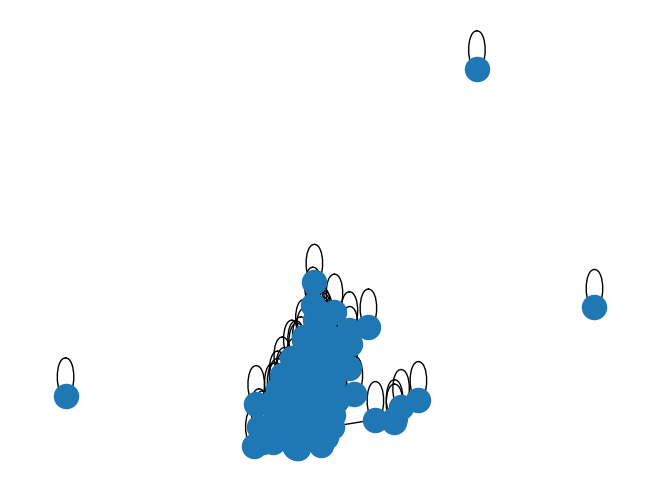

In [69]:
nx.draw(G_onet)

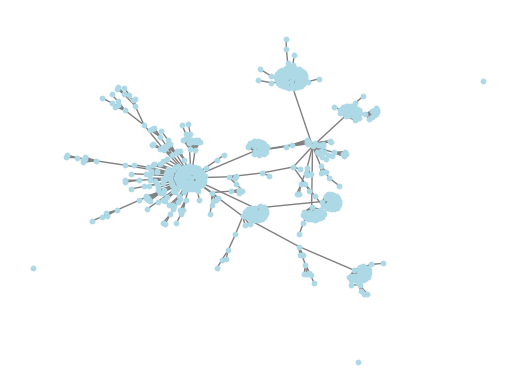

In [70]:
## MAXIMUM SPANNING TREE
# Find the minimum spanning tree
T = nx.minimum_spanning_tree(G_onet)

# Visualize the graph and the minimum spanning tree
pos = nx.spring_layout(T)
nx.draw_networkx_nodes(T, pos, node_color="lightblue", node_size=10)
nx.draw_networkx_edges(T, pos, edge_color="grey")
plt.axis("off")
plt.show()


# REPETIMOS EL EJERCICIO PERO CON LOS 238 GRUPOS

In [71]:
features_occupations

,onet_code,Element ID,Data Value,element_id,year
0,11-1011,2.A.1.a,4.060,2.A.1.a_skills,2024
1,11-1011,2.A.1.b,4.000,2.A.1.b_skills,2024
2,11-1011,2.A.1.c,4.120,2.A.1.c_skills,2024
3,11-1011,2.A.1.d,4.125,2.A.1.d_skills,2024
4,11-1011,2.A.1.e,3.065,2.A.1.e_skills,2024
...,...,...,...,...,...
85576,53-7121,2.C.7.e,1.190,2.C.7.e_knowledge,2024
85577,53-7121,2.C.8.a,3.150,2.C.8.a_knowledge,2024
85578,53-7121,2.C.8.b,1.810,2.C.8.b_knowledge,2024
85579,53-7121,2.C.9.a,2.130,2.C.9.a_knowledge,2024


In [72]:
features_occupations["onet_code_reclasificado"] = features_occupations["onet_code"].replace({i:j for i,j in C123_exporta.query("clasificador=='onet'")[["codigo", "codigo_nuevo"]].to_records(index = False)})

<ipython-input-72-64c377f11e04>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_occupations["onet_code_reclasificado"] = features_occupations["onet_code"].replace({i:j for i,j in C123_exporta.query("clasificador=='onet'")[["codigo", "codigo_nuevo"]].to_records(index = False)})
<ipython-input-72-64c377f11e04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_occupations["onet_code_reclasificado"] = features_occupations["onet_code"].replace({i:j for i,j in C123_exporta.query("clasificador=='onet'")[["co

In [73]:
features_occupations_recod =features_occupations.groupby(["onet_code_reclasificado", "element_id"]).agg({"Data Value" : "mean"}).reset_index()
features_occupations_recod

,onet_code_reclasificado,element_id,Data Value
0,1,1.A.1.a.1_abilities,4.052609
1,1,1.A.1.a.2_abilities,4.084783
2,1,1.A.1.a.3_abilities,4.373913
3,1,1.A.1.a.4_abilities,4.036522
4,1,1.A.1.b.1_abilities,3.161304
...,...,...,...
25615,238,2.C.7.e_knowledge,1.180000
25616,238,2.C.8.a_knowledge,3.470000
25617,238,2.C.8.b_knowledge,2.190000
25618,238,2.C.9.a_knowledge,2.090000


In [74]:
features_occupations_recod["year"] = 2024
trade_cols = {'time':'year', 'loc':'element_id', 'prod':'onet_code_reclasificado', 'val':'Data Value'}
prox_df_recod = proximity(features_occupations_recod, trade_cols)
prox_df_recod

2024


,year,onet_code_reclasificado_1,onet_code_reclasificado_2,proximity
0,2024,1,1,1.000000
1,2024,1,2,0.216667
2,2024,1,3,0.133333
3,2024,1,4,0.133333
4,2024,1,5,0.350000
...,...,...,...,...
47956,2024,238,233,0.685185
47957,2024,238,235,0.534483
47958,2024,238,236,0.648148
47959,2024,238,237,0.763636


In [86]:
prox_df_recod.to_csv("output/proximidad_recodificada.csv", index = False)

In [81]:
## Creamos link si la proximidad es mayor a 0.5
prox_df_link_recod = prox_df_recod.query("proximity>0.4")
prox_df_link_recod

,year,onet_code_reclasificado_1,onet_code_reclasificado_2,proximity
0,2024,1,1,1.000000
9,2024,1,10,0.650000
10,2024,1,11,0.700000
12,2024,1,14,0.433333
16,2024,1,19,0.600000
...,...,...,...,...
47956,2024,238,233,0.685185
47957,2024,238,235,0.534483
47958,2024,238,236,0.648148
47959,2024,238,237,0.763636


In [82]:
## Creamos la gráfica
G_onet_recod = nx.from_pandas_edgelist(prox_df_link_recod, "onet_code_reclasificado_1", "onet_code_reclasificado_2")

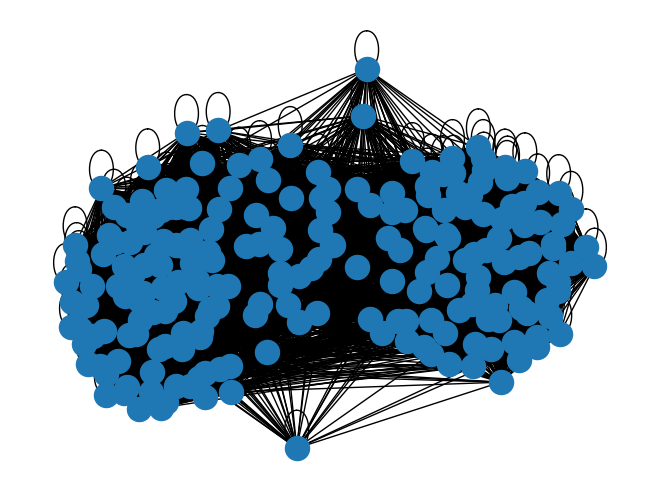

In [83]:
nx.draw(G_onet_recod)

In [84]:
len(G_onet_recod.nodes)

219

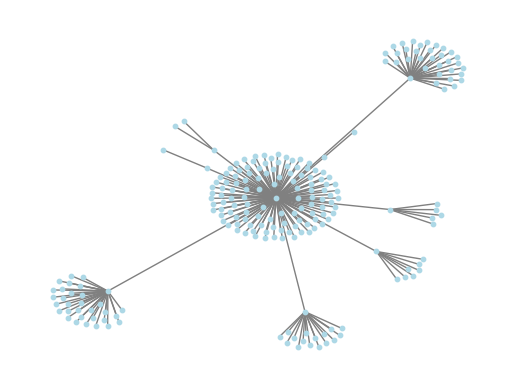

In [85]:
## MAXIMUM SPANNING TREE
# Find the minimum spanning tree
T = nx.minimum_spanning_tree(G_onet_recod)

# Visualize the graph and the minimum spanning tree
pos = nx.spring_layout(T)
nx.draw_networkx_nodes(T, pos, node_color="lightblue", node_size=10)
nx.draw_networkx_edges(T, pos, edge_color="grey")
plt.axis("off")
plt.show()

In [ ]:
# move network from networkx to cy
T.node = T.nodes
cytoscape_network = cy.from_networkx(T)

res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))

<Response [200]>

In [90]:
inicia = 0
umbrales = []
for i in range(20):
  umbrales.append(inicia)
  inicia += 0.05
umbrales


[0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35,
 0.39999999999999997,
 0.44999999999999996,
 0.49999999999999994,
 0.5499999999999999,
 0.6,
 0.65,
 0.7000000000000001,
 0.7500000000000001,
 0.8000000000000002,
 0.8500000000000002,
 0.9000000000000002,
 0.9500000000000003]

In [93]:
guarda_df = []

for umbral in umbrales:
  df_parcial = prox_df_recod.query(f"proximity>{umbral}")
  df_parcial["umbral"] = round(umbral, 2)
  guarda_df.append(df_parcial)


<ipython-input-93-a99b6ede8ed4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial["umbral"] = round(umbral, 2)
<ipython-input-93-a99b6ede8ed4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial["umbral"] = round(umbral, 2)
<ipython-input-93-a99b6ede8ed4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [96]:
proximidad_umbrales = pd.concat(guarda_df, ignore_index = True)
proximidad_umbrales

,year,onet_code_reclasificado_1,onet_code_reclasificado_2,proximity,umbral
0,2024,1,1,1.000000,0.00
1,2024,1,2,0.216667,0.00
2,2024,1,3,0.133333,0.00
3,2024,1,4,0.133333,0.00
4,2024,1,5,0.350000,0.00
...,...,...,...,...,...
434685,2024,233,233,1.000000,0.95
434686,2024,235,235,1.000000,0.95
434687,2024,236,236,1.000000,0.95
434688,2024,237,237,1.000000,0.95


In [102]:
for umbral in proximidad_umbrales["umbral"].unique():
  df_umbral = proximidad_umbrales.query(f'onet_code_reclasificado_1==30 and umbral=={umbral}')
  conexiones = df_umbral.shape[0]

  print(f"Grupo 30 cantidad de conexiones {conexiones} con umbral {umbral}")
  print(f"Mis vecinos son\n{df_umbral['onet_code_reclasificado_2'].to_list()}")

Grupo 30 cantidad de conexiones 219 con umbral 0.0
Mis vecinos son
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 213, 215, 216, 217, 218, 220, 221, 223, 224, 225, 22

In [103]:
proximidad_umbrales.to_csv("output/proximidad_umbrales.csv", index = False)

In [104]:
proximidad_umbrales

,year,onet_code_reclasificado_1,onet_code_reclasificado_2,proximity,umbral
0,2024,1,1,1.000000,0.00
1,2024,1,2,0.216667,0.00
2,2024,1,3,0.133333,0.00
3,2024,1,4,0.133333,0.00
4,2024,1,5,0.350000,0.00
...,...,...,...,...,...
434685,2024,233,233,1.000000,0.95
434686,2024,235,235,1.000000,0.95
434687,2024,236,236,1.000000,0.95
434688,2024,237,237,1.000000,0.95
